# Week 2. Day 3. Exercises from Chapter 5 of FSStDS. 
## Fundamentals of Social Data Science. MT 2022

Within your study pod discuss the following questions. Please submit an individual assignment by 12:30pm Monday, October 24, 2022 on Canvas. 

# Exercise - build your own Reddit crawler

Reddit is a vast resource of community forums as a viable site for a large amount of research in computational social science. Some of that research involves interacting with the Reddit platform. We will not be doing much of that. However, we can still do a vast amount simply by requesting data from the site and analysing it. 

In this exercise you will have to be clear about how you want to optimise something for specificity or generality. More general might work at different time periods, different subreddits or users. More specific might be focusing or accounting for features within a specific subreddit or community. 

We cannot do everything in this crawler so it is better to pick a specific task and then test that under a number of circumstances than it is to make it too general.  

Rubric: 
    
This exercise will be in three parts. 
- **Part 1.** The setup [10pts]. The example below gives a sense of this. You should be able to articulate a very simple research question, an operationalisation of the concepts, a detail of the unit of analysis, the variables of interest, and challenges. This should not be overly involved - see the example below is rather terse (though I suspect you could do better). Including literature helps but is not necessary. 
- **Part 2.** The code [10pts]. What code will you use? Place the code in the answer below your setup. When run by a TA it does not have to produce the same result that you received, but it should produce a result. The 10 points will remain vague but the TAs will be considering all of the FREE mnenomic (is it functioning, robust, elegant, efficient). Particularly for online data, robustness is really important. 
- **Part 3.** The analysis [5pts]. What analysis will you use? We have not introduced any real statistical concepts so I expect this to be generally comparative at this point. You are welcome to report descriptive data, normalised data, or even a statistical model if you feel comfortable, but it should be very, very simple. 

Think of this like your first 'towardsdatascience' blog post. In that sense, we are not looking for academic tier work (just yet) but work that simply explains the concepts and setup, shows a way to collect some limited data, and then shows a simple analysis. 

The more general you can make the code the better (to a point). But in that sense, be careful with hard coding variable names or options. Try to avoid spaghetti code if possible. 

# Part 1. Setup
__answer below here__
Many countries have a national subreddit. These subreddits contain both nationals as well as international participants (akin to non-scandinavian "scanfans" in the Oxford Scandinavian Society). However, the subreddits might cater differently to nationals versus internationals through the discourse by using more or less English versus the national language. This is what I will investigate in this assignment. 

__Research question:__ 
To what extent do the Scandinavian subreddits use their own language versus English in conversation?

__Operationalisation of concepts:__
Figuring out the language of a (short) utterance at scale can be difficult. For this task I will use the package [`langdetect`](https://pypi.org/project/langdetect/), which is based on Google software. To ensure sufficient interaction I will investigate the top 100 yearly posts of Denmark, Sweden, and Norway respectively.

__Unit of analysis:__
This analysis will focus on the comments as this is most interaction happens. I will limit myself to the comments that are immediately returned to limit the complexity of the code (though if I find a simple way to get all comments I'll do that)

__Variables of interest:__ 
For each tweet I will store the following variables: 
- PostId
- CommentId
- CommentText
- CommentLanguage (derived from `langdetect`)
- SubredditId

This will allow me to create the following table (with Psedu values)

Subreddit | Language | EnglishPct
--- | --- | ---
Denmark | da | 12%
Sweden | sv | 24%
Norway | da | 32%

I might then do some simple statistical analysis (an Anova) to gauge whether there exists a difference between the countries.  


__Technical challenges__
Firstly, there might be technical difficulties with scraping comments (which I hope will be manageable). Secondly, there are some statistical challenges with interdepence between the comments. For instance, the language of the title as well as the popularity of the post might influence the amounts (i.e. a highly popular post with an English title might have an influx of English speakers from /r/all). Furthermore, the language of the top-level comment might also influence the language of the conversations. For the sake of simplicity, however, I won't account for this methodologically.

Another technical challenge is that all three chosen languages are so-called "low-resource" languages. There is simply not nearly as good technology for working with these languages as for English (though [valiant efforts are undertaken](https://www.kennethenevoldsen.com/project/dacy/)). I will remedy this by focusing on the proportion of English comments and thus assume that the rest are probably Danish/Swedish/Norwegian. 

# Part 2. Code 

In [78]:
#################################
from pathlib import Path
import pandas as pd
import langdetect
import praw
import json
import matplotlib.pyplot as plt
from typing import Generator, Tuple
from tqdm import tqdm

NATIONALITY_DICT = {"sv": "sweden", "da": "denmark", "no": "norway"}

def read_json(filename: Path) -> dict:
    """Read a JSON file.
    Args:
        filename (Path): The path to the JSON file.
    Returns:
        dict: The contents of the JSON file.
    """
    with open(filename) as f:
        return json.load(f)

def get_top_posts(reddit: praw.Reddit, subreddit: str, n: int = 10) -> Generator:
    """Get top posts from a subreddit using the Reddit API.
    Args:
        reddit (praw.Reddit): A Reddit instance.
        subreddit (str): The name of the subreddit.
        n (int): The number of posts to retrieve.
    Returns:
        Generator: A generator of top posts.
    """
    return reddit.subreddit(subreddit).top(limit=n, time_filter="year")

reddit_config = read_json(Path("../reddit_config.json"))
reddit = praw.Reddit(
    client_id=reddit_config["client_id"],
    client_secret=reddit_config["client_secret"],
    user_agent="SDS Scraper Jonathan",
)

def add_post_info(post: praw.models.Submission) -> dict:
    """Add post info to a dictionary.
    Args:
        post (praw.models.Submission): A Reddit post.
    Returns:
        dict: A dictionary with post info.
    """
    return {
        "title": post.title,
        "id": post.id,
        "subreddit": post.subreddit.display_name,
        "language": detect_lang(post.title),
    }

def detect_lang(text: str) -> str:
    """Detect the language of a text.
    Args:
        text (str): The text to detect the language of.
    Returns:
        str: The language of the text.
    """
    try:
        return langdetect.detect(text)
    except langdetect.lang_detect_exception.LangDetectException:
        return "unknown"

def add_comment_info(comment: praw.models.Comment) -> dict:
    """Add comment info to a dictionary.
    Args:
        comment (praw.models.Comment): A Reddit comment.
    Returns:
        dict: A dictionary with comment info.
    """
    return {
        "id": comment.id,
        "post_id": comment.submission.id,
        "body": comment.body,
        "language": detect_lang(comment.body),
    }

def process_subreddit(reddit: praw.Reddit, subreddit: str, n: int = 10) -> Tuple[pd.DataFrame, pd.DataFrame]:
    post_list = []
    comment_list = []
    for top_post in tqdm(get_top_posts(reddit, subreddit=subreddit, n=n)):
        post_list.append(add_post_info(top_post))
        top_post.comments.replace_more(limit=0)
        for comment in top_post.comments.list():
            comment_list.append(add_comment_info(comment))
    return (pd.DataFrame(post_list), pd.DataFrame(comment_list))
# Answer below here

In [39]:
N=10
postdf_list = []
commentdf_list = []
for subreddit in tqdm(NATIONALITY_DICT.values()):
    postdf, commentdf = process_subreddit(reddit, subreddit=subreddit, n=N)
    postdf_list.append(postdf)
    commentdf_list.append(commentdf)

postdf = pd.concat(postdf_list)
commentdf = pd.concat(commentdf_list)

10it [00:57,  5.70s/it]0:00<?, ?it/s]
10it [01:10,  7.03s/it]0:57<01:54, 57.06s/it]
10it [00:44,  4.50s/it]2:07<01:04, 64.87s/it]
100%|██████████| 3/3 [02:52<00:00, 57.47s/it]


In [46]:
merge_df = pd.merge(commentdf, postdf, left_on="post_id", right_on="id", suffixes=("_comment", "_post"))

           id_comment
subreddit            
Denmark          2307
Norway           2355
sweden           2697


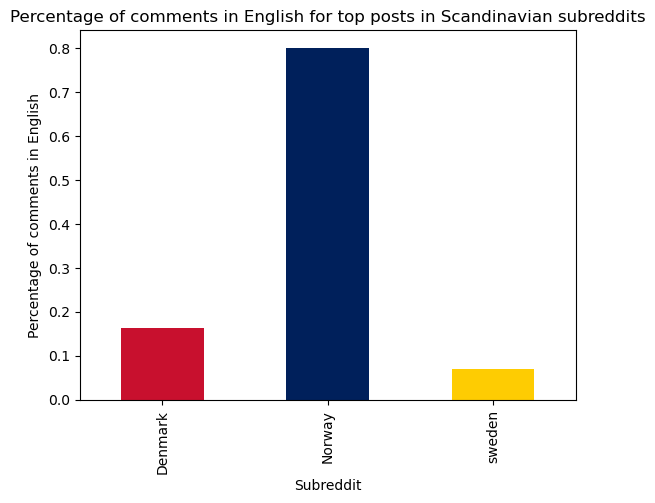

In [82]:
merge_df["is_english"] = merge_df["language_comment"] == "en"
percentage_english = merge_df.groupby("subreddit").agg({"is_english": "mean"})
percentage_english.reset_index(inplace=True)
percentage_english.columns = ["subreddit", "percentage_english"]

fig, ax = plt.subplots()
percentage_english.plot.bar(x="subreddit", y="percentage_english", ax=ax, color=["#C8102E", "#00205B", "#FECC02"], legend=False)
ax.set_ylabel("Percentage of comments in English")
ax.set_xlabel("Subreddit")
ax.set_title("Percentage of comments in English for top posts in Scandinavian subreddits")

number_of_comments = merge_df.groupby("subreddit").agg({"id_comment": "count"})
print(number_of_comments)


# Part 3.

**Findings. Make a claim in text using insights from the code below here**
The above analysis show a quite striking difference between Norway and the other two countries. An analysis of the titles (not included for brevity) show the same results. While Denmark and Sweden have relatively minor levels of English spoken, Norway is dominated by the English language. A quick sample shows this to be consistent with the experience of browsing the subreddit. 

The cultural reasons for this are difficult to assess from the data alone. Perusing the data, it seems that much discussion in r/Norway centers around life as an expat (see [this post](https://www.reddit.com/r/Norway/comments/re5znp/no_lies_detected/) and [this post](https://www.reddit.com/r/Norway/comments/skbhj3/norway_here_i_come/)). r/Denmark on the other hand are more focused on domestic matters like [political scandals](https://www.reddit.com/r/Denmark/comments/rffh70/inger_efter_60_dage_i_kachotten/) and our new national hero [Jonas Vingegaard](https://www.reddit.com/r/Denmark/comments/w9k4ij/jonas_fucking_vingegaard/). 

Zooming out, this analysis highlights some of the power of social data science. It enabled me to pose a relatively simple question and with a few lines of code (and a big help from the open source community) come up with an unexpected answer. While actively browsing the three subreddits might have yielded the same insights over time, I definitely couldn't have read ~8000 comments in three minutes(!). 

# Example crawler 

To inspire you, here are a couple examples of tasks that would be at the right scale:

## Talking with flair. 

On a variety of communities on reddit, you can (and sometimes are required to) have flair which is a little tag next to the person. On the /r/ukpolitics subreddit for example flair is used to denote political affiliation. 

__Research question:__ 
Do people who use flair speak differently or behave differently than those who do not? 

__Operationalisation of concepts:__
There are many potential ways to encode 'speak differently or behave differently' that we might operationalise. For this, I will look at a set of the hot 100 posts a subreddit as taking a reasonable sample. 

__Unit of analysis:__ 
For each of these posts I will look at the comments. I will not look at all the comments due to the complexity of navigating the comment tree. Rather, when you query a reddit post it comes down with a truncated set of comments. I will be using these. 

__Variables of interest:__ 
For each of the comments on the stories I will store the following:
- username
- comment text for feature extraction
- coment score
- user flair

Then I will wrangle the data so that we group by flair and take the average of the comment score for each flair. This will be reported in a table showing:

~~~
flair | n_users | n_comments | avg_comment_score
~~~

I will probably truncate that table as I expect a long-tail distribution. 

__Technical challenges__

We know from class how to download a set of posts, but not how to download the post itself and the comments within it, however, it seems that `<postname>.json` will still work so that should be automatable. I plan to use this post.json and not crawl for all of the comments, deleted comments etc... 

In [106]:
# read in CSV files

tweet_df = pd.json_normalize(
    json.load(
        open("dalle2_oct18_2022_tweets.json",'r')))

users_df = pd.json_normalize(
    json.load(
        open("dalle2_oct18_2022_users.json",'r')))

merge_df = tweet_df.merge(users_df, left_on="author_id", right_on="id", how="left")

print(len(tweet_df),len(users_df),len(merge_df))
# Should be 100 79 100

100 79 100


In [131]:
# Answer below here

over1k = merge_df['public_metrics.followers_count'] >= 1000
under1k = over1k == False

len_over1k = ...
len_under1k = ...

len_over1k = len(merge_df[over1k])
len_under1k = len(merge_df[under1k])

29 71


In [137]:
merge_df['mention_count'] = merge_df['entities.mentions'].map(lambda x: len(x) if type(x) == list else 0)

# print(merge_df['mention_count'].value_counts())

over1k_nummention = len(merge_df[over1k][merge_df[over1k]['mention_count'] > 0])

under1k_nummention = len(merge_df[under1k][merge_df[under1k]['mention_count'] > 0])

print(f"The percentage of tweets from those with over 1k followers that have mentions is  {over1k_nummention / len_over1k:0.1%}",
      f"The percentage of tweets from those with under 1k followers that have mentions is  {under1k_nummention / len_under1k:0.1%}")

The percentage of tweets from those with over 1k followers that have mentions is  24.1% The percentage of tweets from those with under 1k followers that have mentions is  11.3%
